In [206]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Filter Data According to badSampleIdxList txt file

In [207]:
# filter 
def filterBadData(X_dataset, y_dataset, badSampleIdxListTXT):
    print("original shape = ", X_dataset.shape)
    teleportation_threshold = 0.2 # allowed maximum teleportation distance
    for i in range(TIME_STEPS-1):

        diff_x = X_dataset[:, 2*i] - X_dataset[:, 2*i+2]
        diff_y = X_dataset[:, 2*i+1] - X_dataset[:, 2*i+3]
        dist = diff_x * diff_x + diff_y * diff_y
        filt = dist > (teleportation_threshold * teleportation_threshold)
        X_dataset[filt, 2*i+2] = X_dataset[filt, 2*i]
        X_dataset[filt, 2*i+3] = X_dataset[filt, 2*i+1]

    # remove records that have only outliers
    amplitute = np.sum(np.abs(X_dataset), axis=1)
    filt = amplitute > 0.01
    X_dataset = X_dataset[filt]
    y_dataset = y_dataset[filt]

    if badsampleIdxFile:
        badSampleIdxList = np.loadtxt(badSampleIdxListTXT)
        filt = np.ones(len(X_dataset), dtype=bool)
        for idx in badSampleIdxList:
            idx = int(idx)
            filt[idx] = False

        X_dataset = X_dataset[filt]
        y_dataset = y_dataset[filt]

    return X_dataset, y_dataset


# Choose the Dataset

In [208]:
data_twoPeople = [
    'model/point_history_classifier/point_history.csv', 
    'model/point_history_classifier/point_history_xinyang.csv'
    ]
badSampleIdxList_twoPeople = [
    "badSampleIdxList_yipeng.txt", 
    "badSampleIdxList_xinyang.txt"
    ]
# model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_2P.hdf5'
model_save_path = 'model/point_history_classifier/point_history_classifier_LSTM_noCross.hdf5'
# label_names = ["Clockwise", "Counter Clockwise", "Checkmark", "Right", "Left", "None"]
label_names = ["Clockwise", "Counter Clockwise", "Checkmark", "Cross", "Right", "Left", "None"]

# How many classes?

In [209]:
NUM_CLASSES = 7

# 入力長

In [210]:
TIME_STEPS = 30 #16 or 30
DIMENSION = 2

# Load Data

In [211]:
X_list = []
y_list = []
for csvfileName, badsampleIdxFile in zip(data_twoPeople, badSampleIdxList_twoPeople):
    X_dataset = np.loadtxt(csvfileName, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))
    y_dataset = np.loadtxt(csvfileName, delimiter=',', dtype='int32', usecols=(0))

    X_dataset, y_dataset = filterBadData(X_dataset, y_dataset, badsampleIdxFile) # comment if you want to keep mutation 
    X_list.append(X_dataset)
    y_list.append(y_dataset)

X_dataset = np.vstack(X_list)
y_dataset = np.concatenate(y_list)
X_dataset.shape, y_dataset.shape

original shape =  (2409, 60)
original shape =  (2520, 60)


((4183, 60), (4183,))

Add Gaussian

In [212]:
mu, sigma = 0, 0.01
noise = np.random.normal(mu, sigma, X_dataset.shape)
X_dataset += noise

In [213]:
# Clean data with Gaussian noise
X_origin = X_dataset
y_origin = y_dataset

# Process Data (Augmentation)

2273 Clockwise


(4183, 60)

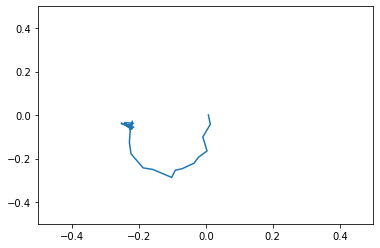

In [216]:
from matplotlib import pyplot as plt

idx = np.random.randint(100, 4000)

x = X_dataset[idx,::2]
y = X_dataset[idx,1::2]
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])
print(idx, label_names[y_dataset[idx]])
plt.plot(x, y)
X_dataset.shape


Create the Transformation Function H

In [217]:
from scipy.spatial.transform import Rotation
def rotationMatrix(angle):
    r = Rotation.from_quat([0, 0, np.sin(np.pi/(360/angle)), np.cos(np.pi/(360/angle))])
    return r.as_matrix()

def translateMatrix(x_dist, y_dist):
    t = np.identity(3)
    t[0,2] = x_dist
    t[1,2] = y_dist
    return t

def scaleMatrix(x_scale, y_scale):
    s = np.identity(3)
    s[0, 0] = x_scale
    s[1, 1] = y_scale
    return s


'''
CCW, CW: rotation, scale, translate
check: scale, translate
cross: rotation, scale, translate
right, left: scale, translate
'''
H_rotation_list = [rotationMatrix(angle) for angle in range(60, 360, 60)]
H_translation_list = [translateMatrix(dx, dy) for dx in np.arange(-0.2, 0.2, 0.05) for dy in np.arange(-0.2, 0.2, 0.05)]
H_scale_list = [scaleMatrix(x_scale, y_scale) for x_scale in np.arange(0.8, 1.2, 0.05) for y_scale in np.arange(0.8, 1.2, 0.05)]

CCW_n_CW_dup_times = 4          # number of fake copies by duplicating original samples
cross_dup_times = 6             # number of fake copies by duplicating original samples
check_dup_times = 4             # number of fake copies by duplicating original samples
left_n_right_dup_times = 4      # number of fake copies by duplicating original samples


np.random.seed(42)
CCW_n_CW_dup_H_random_idx = [
    np.random.permutation(len(H_rotation_list))[:CCW_n_CW_dup_times], 
    np.random.permutation(len(H_translation_list))[:CCW_n_CW_dup_times],
    np.random.permutation(len(H_scale_list))[:CCW_n_CW_dup_times]
]
cross_dup_H_random_idx = [
    np.random.permutation(len(H_rotation_list))[:cross_dup_times],
    np.random.permutation(len(H_translation_list))[:cross_dup_times],
    np.random.permutation(len(H_scale_list))[:cross_dup_times]
]
check_dup_H_random_idx = [
    np.random.permutation(len(H_translation_list))[:check_dup_times],
    np.random.permutation(len(H_scale_list))[:check_dup_times]
]
left_n_right_random_idx = [
    np.random.permutation(len(H_translation_list))[:left_n_right_dup_times],
    np.random.permutation(len(H_scale_list))[:left_n_right_dup_times]
]


CCW_n_CW_dup_H = []
for rotation_H_idx, translation_H_idx, scale_H_idx in zip(CCW_n_CW_dup_H_random_idx[0], CCW_n_CW_dup_H_random_idx[1], CCW_n_CW_dup_H_random_idx[2]):
    CCW_n_CW_dup_H.append(H_rotation_list[rotation_H_idx].dot(H_translation_list[translation_H_idx]).dot(H_scale_list[scale_H_idx]))

cross_dup_H = []
for rotation_H_idx, translation_H_idx, scale_H_idx in zip(cross_dup_H_random_idx[0], cross_dup_H_random_idx[0], cross_dup_H_random_idx[0]):
    cross_dup_H.append(H_rotation_list[rotation_H_idx].dot(H_translation_list[translation_H_idx]).dot(H_scale_list[scale_H_idx]))

check_dup_H = []
for translation_H_idx, scale_H_idx in zip(check_dup_H_random_idx[0], check_dup_H_random_idx[1]):
    check_dup_H.append(H_translation_list[translation_H_idx].dot(H_scale_list[scale_H_idx]))

left_n_right_dup_H = []
for translation_H_idx, scale_H_idx in zip(left_n_right_random_idx[0], left_n_right_random_idx[1]):
    left_n_right_dup_H.append(H_translation_list[translation_H_idx].dot(H_scale_list[scale_H_idx]))


H_dict = {0:CCW_n_CW_dup_H, 1:CCW_n_CW_dup_H, 2:check_dup_H, 3:cross_dup_H, 4:left_n_right_dup_H, 5:left_n_right_dup_H}

# r = rotationMatrix(30).as_matrix()
# t = translateMatrix(1, 1)
# s = scaleMatrix(0.8, 0.8)

# H = np.dot(t, s)
# H = np.dot(H, r)
# plot to check
# plt.xlim([-0.5,0.5])
# plt.ylim([-0.5,0.5])
# print(idx, label_names[y_dataset[idx]])
# plt.plot(new_sample[:,0], new_sample[:,1])

In [218]:
def transformDataset(data=X_dataset, label=y_dataset, H_dict=H_dict):
    for sample_idx in range(len(data)):
        x = data[sample_idx,::2]
        y = data[sample_idx,1::2]
        l = label[sample_idx]

        one_sample = np.vstack([x, y, np.ones(30,)]).T

        for H in H_dict[l]:
            # do transformation to this sample
            transed_sample = np.dot(one_sample, H)
            transed_sample[:, :2] /= transed_sample[:, 2:]
            transed_sample = np.reshape(transed_sample[:,:2], (1, 60))
            data = np.append(data, transed_sample, axis=0)
            label = np.append(label, label[sample_idx])
    return data, label

X_dataset_org = X_dataset.copy()
y_dataset_org = y_dataset.copy()
X_dataset, y_dataset = transformDataset(X_dataset, y_dataset, H_dict)

X_dataset.shape, y_dataset.shape

((20915, 60), (20915,))

Delete the Cross Class

In [157]:
filt = y_dataset != 3
X_dataset = X_dataset[filt]
y_dataset = y_dataset[filt]

y_dataset[y_dataset == 4] = 3
y_dataset[y_dataset == 5] = 4
y_dataset[y_dataset == 6] = 5

Print the Dataset Info before NoneType added in

In [219]:
print(X_dataset.shape, y_dataset.shape)

label_count = {}
for l in y_dataset:
    label_count[label_names[l]] = (label_count.get(label_names[l], 0) + 1)
print(label_count)

(20915, 60) (20915,)
{'Counter Clockwise': 3790, 'Clockwise': 3995, 'Checkmark': 3540, 'Cross': 3205, 'Left': 3420, 'Right': 2965}


# Add NoneType Data

708 stop_moving_data


(4000,)

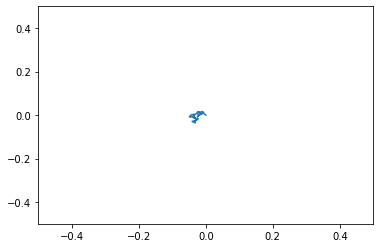

In [204]:
import random
from matplotlib import pyplot as plt

random_walking = 2000
maxMobiliarbus = 0.2
stopMobiliarbus = 1e-2
sudden_points = 1000
stop_moving = 1000

random_walk_data = []
for sample_num in range(random_walking):
    samples = [0,0]
    for _ in range(TIME_STEPS-1):
        dx, dy = random.uniform(-1, 1) * maxMobiliarbus, random.uniform(-1, 1) * maxMobiliarbus
        newx, newy = samples[-2]+dx, samples[-1]+dy
        while not (-0.5<=newx<=0.5 and -0.5 <=newy<=0.5):
            dx, dy = random.uniform(-1, 1) * maxMobiliarbus, random.uniform(-1, 1) * maxMobiliarbus
            newx, newy = samples[-2]+dx, samples[-1]+dy
        samples += [newx, newy]
    random_walk_data.append(np.asarray(samples))
random_walk_data = np.asarray(random_walk_data)

sudden_points_data = []
for sample_num in range(sudden_points):
    sample = np.random.rand(TIME_STEPS*2)*2 - 0.55
    sudden_points_data.append(sample)
sudden_points_data = np.asarray(sudden_points_data)

stop_moving_data = []
for sample_num in range(stop_moving):
    samples = [0,0]
    for _ in range(TIME_STEPS-1):
        dx, dy = random.uniform(-1, 1) * stopMobiliarbus, random.uniform(-1, 1) * stopMobiliarbus
        newx, newy = samples[-2]+dx, samples[-1]+dy
        while not (-0.5<=newx<=0.5 and -0.5 <=newy<=0.5):
            dx, dy = random.uniform(-1, 1) * stopMobiliarbus, random.uniform(-1, 1) * stopMobiliarbus
            newx, newy = samples[-2]+dx, samples[-1]+dy
        samples += [newx, newy]
    stop_moving_data.append(np.asarray(samples))
stop_moving_data = np.asarray(stop_moving_data)

nonetype_label = np.zeros(shape=(random_walking+ sudden_points + stop_moving, ),dtype=int)+(len(label_names)-1)

idx = idx = np.random.randint(0, 1000)
x = stop_moving_data[idx,::2]
y = stop_moving_data[idx,1::2]
plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])
print(idx, "stop_moving_data")
plt.plot(x, y)

nonetype_label.shape

Add all nonetype data into main dataset

In [160]:
print("Before adding nonetype", X_dataset.shape, y_dataset.shape)
X_dataset = np.vstack([X_dataset, random_walk_data, sudden_points_data, stop_moving_data])
y_dataset = np.hstack([y_dataset, nonetype_label])
print("After adding nonetype", X_dataset.shape, y_dataset.shape)
print(y_dataset)


Before adding nonetype (17710, 60) (17710,)
After adding nonetype (21710, 60) (21710,)
[1 1 1 ... 5 5 5]


In [161]:
from collections import Counter
c = Counter(y_dataset)
print(c)


label_count = {}
for l in y_dataset:
    label_count[label_names[l]] = (label_count.get(label_names[l], 0) + 1)
print(label_count)

Counter({5: 4000, 0: 3995, 1: 3790, 2: 3540, 4: 3420, 3: 2965})
{'Counter Clockwise': 3790, 'Clockwise': 3995, 'Checkmark': 3540, 'Left': 3420, 'Right': 2965, 'None': 4000}


Filter for dataset == [✔，×，None]

In [30]:
filt = np.logical_or(np.logical_or(y_dataset==2, y_dataset==3), y_dataset==6)
X_dataset = X_dataset[filt]
y_dataset = y_dataset[filt]

y_dataset[y_dataset == 2] = 0
y_dataset[y_dataset == 3] = 1
y_dataset[y_dataset == 6] = 2


In [31]:
from collections import Counter
c = Counter(y_dataset)
print(c)

Counter({2: 8000, 0: 3540, 1: 3205})


In [162]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

Print the Train Set Info

In [163]:
print(X_train.shape, y_train.shape)

label_count = {}
for l in y_train:
    label_count[label_names[l]] = (label_count.get(label_names[l], 0) + 1)
print(label_count)

(16282, 60) (16282,)
{'None': 3034, 'Left': 2518, 'Right': 2221, 'Clockwise': 3016, 'Checkmark': 2662, 'Counter Clockwise': 2831}


# モデル構築

In [164]:
use_lstm = True
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.1), #0.2
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]), # 16 previous
        tf.keras.layers.Dropout(0.2), #0.5
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2), #0.2
        tf.keras.layers.Dense(15, activation='relu'),
        tf.keras.layers.Dropout(0.5), #0.5
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [165]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 30, 2)             0         
                                                                 
 dropout_2 (Dropout)         (None, 30, 2)             0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1216      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                340       
                                                                 
 dense_3 (Dense)             (None, 6)                 126       
                                                                 
Total params: 1,682
Trainable params: 1,682
Non-traina

In [166]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
# es_callback = tf.keras.callbacks.EarlyStopping(patience=1000, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=500, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)

In [167]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [168]:
model.fit(
    X_train,
    y_train,
    epochs=2000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/2000
126/128 [============================>.] - ETA: 0s - loss: 1.6901 - accuracy: 0.2503
Epoch 00001: saving model to model/point_history_classifier\point_history_classifier_LSTM_noCross.hdf5
128/128 [==============================] - 3s 11ms/step - loss: 1.6879 - accuracy: 0.2517 - val_loss: 1.5108 - val_accuracy: 0.3425
Epoch 2/2000
121/128 [===========================>..] - ETA: 0s - loss: 1.3939 - accuracy: 0.4418
Epoch 00002: saving model to model/point_history_classifier\point_history_classifier_LSTM_noCross.hdf5
128/128 [==============================] - 1s 8ms/step - loss: 1.3869 - accuracy: 0.4451 - val_loss: 1.2337 - val_accuracy: 0.5153
Epoch 3/2000
125/128 [============================>.] - ETA: 0s - loss: 1.2183 - accuracy: 0.5201
Epoch 00003: saving model to model/point_history_classifier\point_history_classifier_LSTM_noCross.hdf5
128/128 [==============================] - 1s 8ms/step - loss: 1.2178 - accuracy: 0.5205 - val_loss: 1.1195 - val_accuracy: 0.5685
Epo

In [169]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [170]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[4.7937056e-06 2.2882132e-06 9.9997544e-01 1.5653669e-08 1.7466951e-05
 1.4555208e-09]
2


# 混同行列

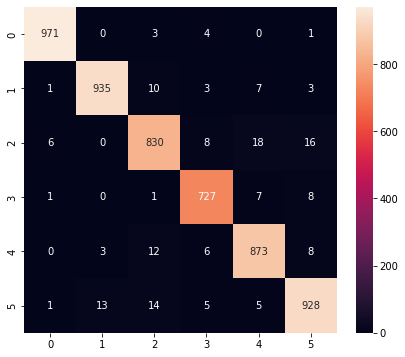

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       979
           1       0.98      0.97      0.98       959
           2       0.95      0.95      0.95       878
           3       0.97      0.98      0.97       744
           4       0.96      0.97      0.96       902
           5       0.96      0.96      0.96       966

    accuracy                           0.97      5428
   macro avg       0.97      0.97      0.97      5428
weighted avg       0.97      0.97      0.97      5428



In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [172]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [173]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier_noCross.tflite'

In [174]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open(tflite_save_path, 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\linyi\AppData\Local\Temp\tmpktpza4sp\assets


INFO:tensorflow:Assets written to: C:\Users\linyi\AppData\Local\Temp\tmpktpza4sp\assets


14928

# 推論テスト

In [175]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [176]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_2:0', 'index': 0, 'shape': array([ 1, 60]), 'shape_signature': array([-1, 60]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [199]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

ValueError: Cannot set tensor: Got value of type FLOAT64 but expected type FLOAT32 for input 0, name: serving_default_input_4:0 

In [226]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

Wall time: 1.98 ms


In [227]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.91341192e-03 1.93613872e-03 1.13033675e-01 8.63234580e-01
 4.45278332e-04 1.14368945e-02]
3
